# Demo code to load in resting-state fMRI and *some* task-state fMRI data

This notebook loads in preprocessed resting-state fMRI and task-state fMRI

Note that both nuisance regression + finite impulse response modeling has been applied to task-state fMRI time series to remove the task-induced influence of hemodynamic lags (see Cole et al., 2019, NeuroImage)

Task activation data can be accessed elsewhere
#### Taku Ito 
#### 9/28/21

In [111]:
import numpy as np
import pandas as pd
import sys
sys.path.insert(0,'glm_scripts')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from importlib import reload
import h5py

#### Modules specific to this repository
import load_data as ld
import postproc_tools as pptools

# Data set parameters (e.g., subject and session files

In [169]:
subIDs=['02','03','04','06','08','09','10','12','14','15','18','20','22','25','27','29','31','17','19','21','24','26','28','30']
# each subject performs 4 task sessions, two from set A and two from set B
session_IDs = ['a1','a2','b1','b2']

# Resting-state fMRI data

#### Load in resting-state fMRI data

Note not all subjects contain a separate resting-state scan (so some subjects will have missing rest data)

In [166]:
ld = reload(ld)
fcmat = []
for sub in subIDs:
    sub_data = ld.loadrsfMRI(sub,space='parcellated')
    fc = np.corrcoef(sub_data)
    # If subject doesn't have data, fc will be 'nan' so exclude
    if not np.isnan(fc).all():
        fcmat.append(fc) # create a list of fcmats, one for each subject
    

Subject 04 | run bold9  does not exist... skipping
Subject 04 | run bold10  does not exist... skipping
Subject 09 | run bold9  does not exist... skipping
Subject 09 | run bold10  does not exist... skipping
Subject 15 | run bold9  does not exist... skipping
Subject 15 | run bold10  does not exist... skipping
Subject 17 | run bold9  does not exist... skipping
Subject 17 | run bold10  does not exist... skipping
Subject 19 | run bold9  does not exist... skipping
Subject 19 | run bold10  does not exist... skipping
Subject 21 | run bold9  does not exist... skipping
Subject 21 | run bold10  does not exist... skipping


#### Plot resting-state functional connectivity (FC, a.k.a. correlation) matrices

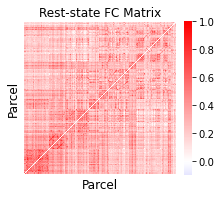

In [188]:
# Average across subjects to obtain a singular Group 
fcmat_groupavg = np.mean(fcmat,axis=0) 
np.fill_diagonal(fcmat_groupavg,0) # set diagonals to 0
# Sort according to the CAB-NP network partition, see Ji et al. (2019) NeuroImage
fcmat_sorted = fcmat_groupavg[ld.indsort,ld.indsort.T] 
plt.figure(figsize=(3,3))
ax = sns.heatmap(fcmat_sorted,square=True,center=0,vmax=1,vmin=-.1,cmap='bwr',cbar_kws={'fraction':0.046})
ax.invert_yaxis()
plt.title('Rest-state FC Matrix',fontsize=12);
plt.xticks([]);
plt.yticks([]);
plt.ylabel('Parcel',fontsize=12);
plt.xlabel('Parcel',fontsize=12);

# Task-state fMRI data

#### Load in processesd task-state data (using FIR modeling for each task block)

Finite impulse response modeling (FIR) removes the hemodynamic response associated with task activity. We only want to residual to measure the moment-to-moment variance

In [180]:
timing_labels = []
task_ts = []
for sub in subIDs:
    for sess in session_IDs:
        sess_key = sub + '_' + sess
        data, labels = ld.loadTaskfMRI_FIR_Timeseries(sess_key,space='parcellated')
        task_ts.append(data)
        timing_labels.append(labels)
        
task_ts = np.asarray(task_ts)
timing_labels = np.asarray(timing_labels)

#### Visualize the time series for 2 regions for a specific subject's session

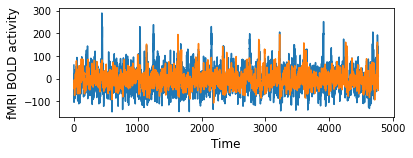

In [184]:
sub = 0
region1 = 1
region2 = 50
plt.figure(figsize=(6,2))
plt.plot(task_ts[0,region1,:],label='region1')
plt.plot(task_ts[0,region2,:],label='region2')
plt.xlabel('Time',fontsize=12);
plt.ylabel('fMRI BOLD activity',fontsize=12);

#### Compute and plot the correlation matrix (task-state FC) across all tasks, and all inter-trial intervals

In [186]:
taskfc = []
for i in range(task_ts.shape[0]):
    corrmat = np.corrcoef(task_ts[i])
    taskfc.append(corrmat)
taskfc_group = np.mean(taskfc,axis=0)

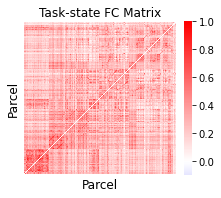

In [187]:
# Average across subjects to obtain a singular Group 
np.fill_diagonal(taskfc_group,0) # set diagonals to 0
# Sort according to the CAB-NP network partition, see Ji et al. (2019) NeuroImage
fcmat_sorted = taskfc_group[ld.indsort,ld.indsort.T] 
plt.figure(figsize=(3,3))
ax = sns.heatmap(fcmat_sorted,square=True,center=0,vmax=1,vmin=-.1,cmap='bwr',cbar_kws={'fraction':0.046})
ax.invert_yaxis()
plt.title('Task-state FC Matrix',fontsize=12);
plt.xticks([]);
plt.yticks([]);
plt.ylabel('Parcel',fontsize=12);
plt.xlabel('Parcel',fontsize=12);

# Load task activation data (example)

#### activation data is loaded for each run separately (8 runs per imaging session)

e.g., subject session 02_a1 has 8 imaging runs

In [215]:
runs = 8
task_activation = []
task_condition_labels = [] # array to list which tasks correspond to which activation maps
for sub in subIDs:
    task_activation.append([])
    task_condition_labels.append([])
    for sess in session_IDs:
        task_activation[-1].append([])
        task_condition_labels[-1].append([])
        sess_key = sub + '_' + sess
        for run in range(1,runs+1):
            data, labels = ld.loadTaskActivations(sess_key,run,space='parcellated')
            task_activation[-1][-1].append(data)
            task_condition_labels[-1][-1].append(labels)

# This should probably be reformatted as a matrix, rather than ragged nested lists (in the future)